# Assignment 1

In this assignment you will learn about linear regression. You have to predict the fuel consumption of different cars based on a set of car features.

1. Write the code to fit the multiple linear regression in Python.
2. Download the dataset Auto MPG and remove the attribute _cylinders_.
3. Split your dataset on train and test data.
4. Test your linear regression on the Auto dataset and compare it with the linear regression implemented in SciKit-learn.
5. Diagnose your linear regression with the diagnostic plots.


In [1]:
# Import all dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from fancyimpute import KNN
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Data Retrieval


In [2]:
# Download and load the Auto MPG dataset from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/auto+mpg)
auto_mpg = fetch_ucirepo(id=9)
data = pd.concat([auto_mpg.data.targets, auto_mpg.data.features], axis=1)
data

,mpg,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,18.0,307.0,8,130.0,3504,12.0,70,1
1,15.0,350.0,8,165.0,3693,11.5,70,1
2,18.0,318.0,8,150.0,3436,11.0,70,1
3,16.0,304.0,8,150.0,3433,12.0,70,1
4,17.0,302.0,8,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,140.0,4,86.0,2790,15.6,82,1
394,44.0,97.0,4,52.0,2130,24.6,82,2
395,32.0,135.0,4,84.0,2295,11.6,82,1
396,28.0,120.0,4,79.0,2625,18.6,82,1


### Data Analyzing


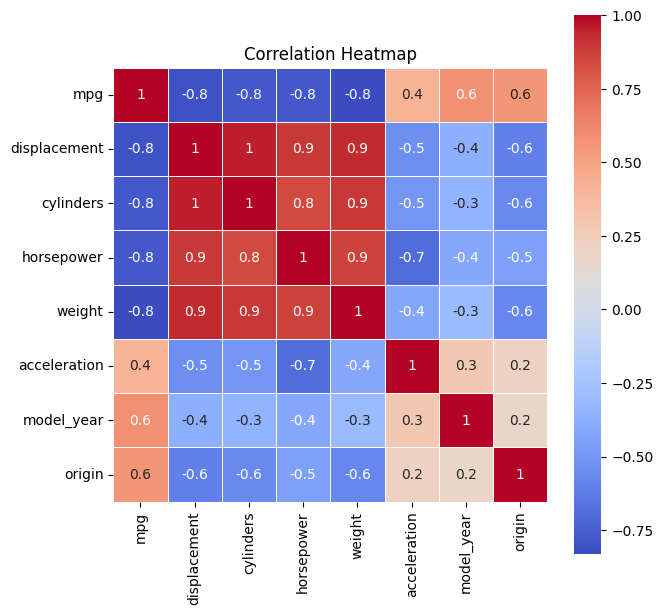

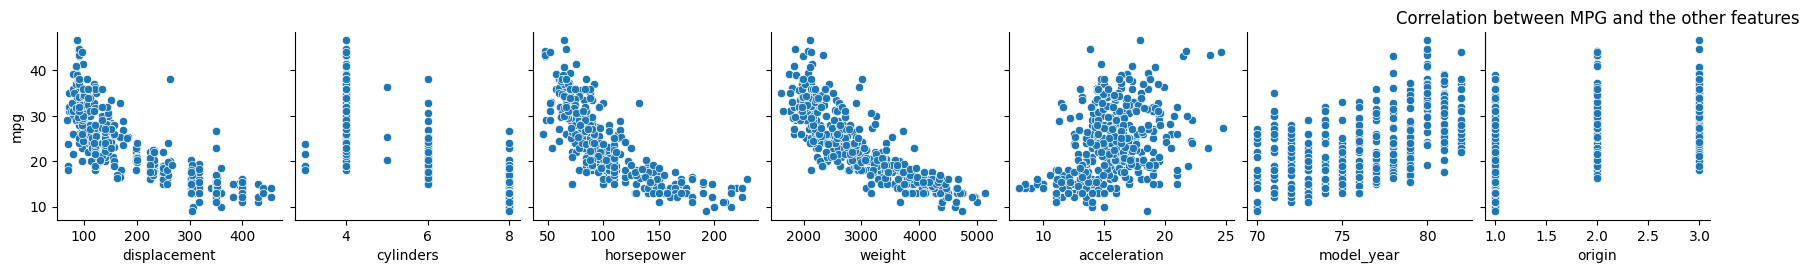

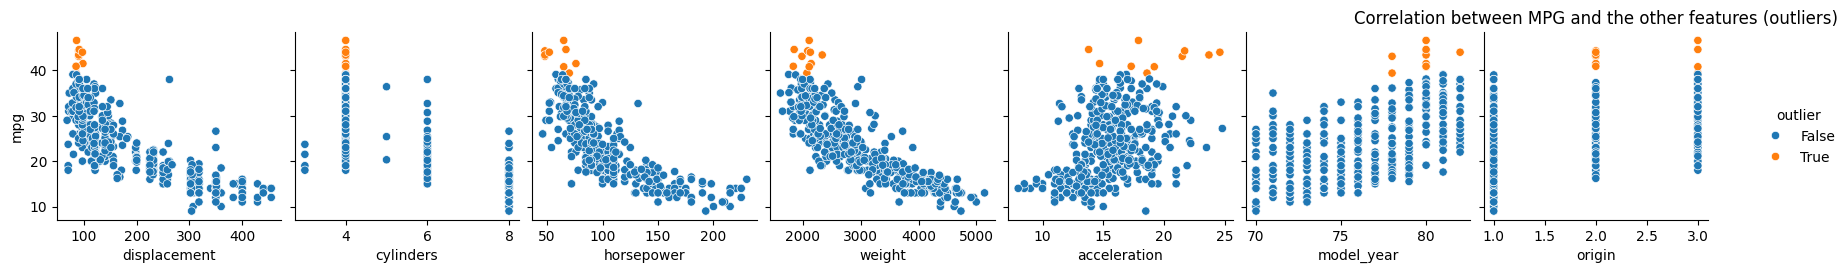

In [3]:
# Exploratory Data Analysis (EDA)
correlation_matrix = data.corr()

_, axis = plt.subplots(1, figsize=(7, 7))
sns.heatmap(
    correlation_matrix,
    annot=True,
    square=True,
    cmap="coolwarm",
    fmt=".1g",
    linewidths=0.5,
    ax=axis,
)
plt.title("Correlation Heatmap")
plt.show()

# Plot the correlation between the MPG and the other features
sns.pairplot(
    data,
    x_vars=[
        "displacement",
        "cylinders",
        "horsepower",
        "weight",
        "acceleration",
        "model_year",
        "origin",
    ],
    y_vars=["mpg"],
)
plt.title("Correlation between MPG and the other features")
plt.show()

# Calculate the z-scores of each feature and mark the outliers, plot the
# correlation between the MPG and the other features
z_scores = np.abs(stats.zscore(data["mpg"]))
data["outlier"] = z_scores > 2
sns.pairplot(
    data,
    x_vars=[
        "displacement",
        "cylinders",
        "horsepower",
        "weight",
        "acceleration",
        "model_year",
        "origin",
    ],
    y_vars=["mpg"],
    hue="outlier",
)
plt.title("Correlation between MPG and the other features (outliers)")
plt.show()

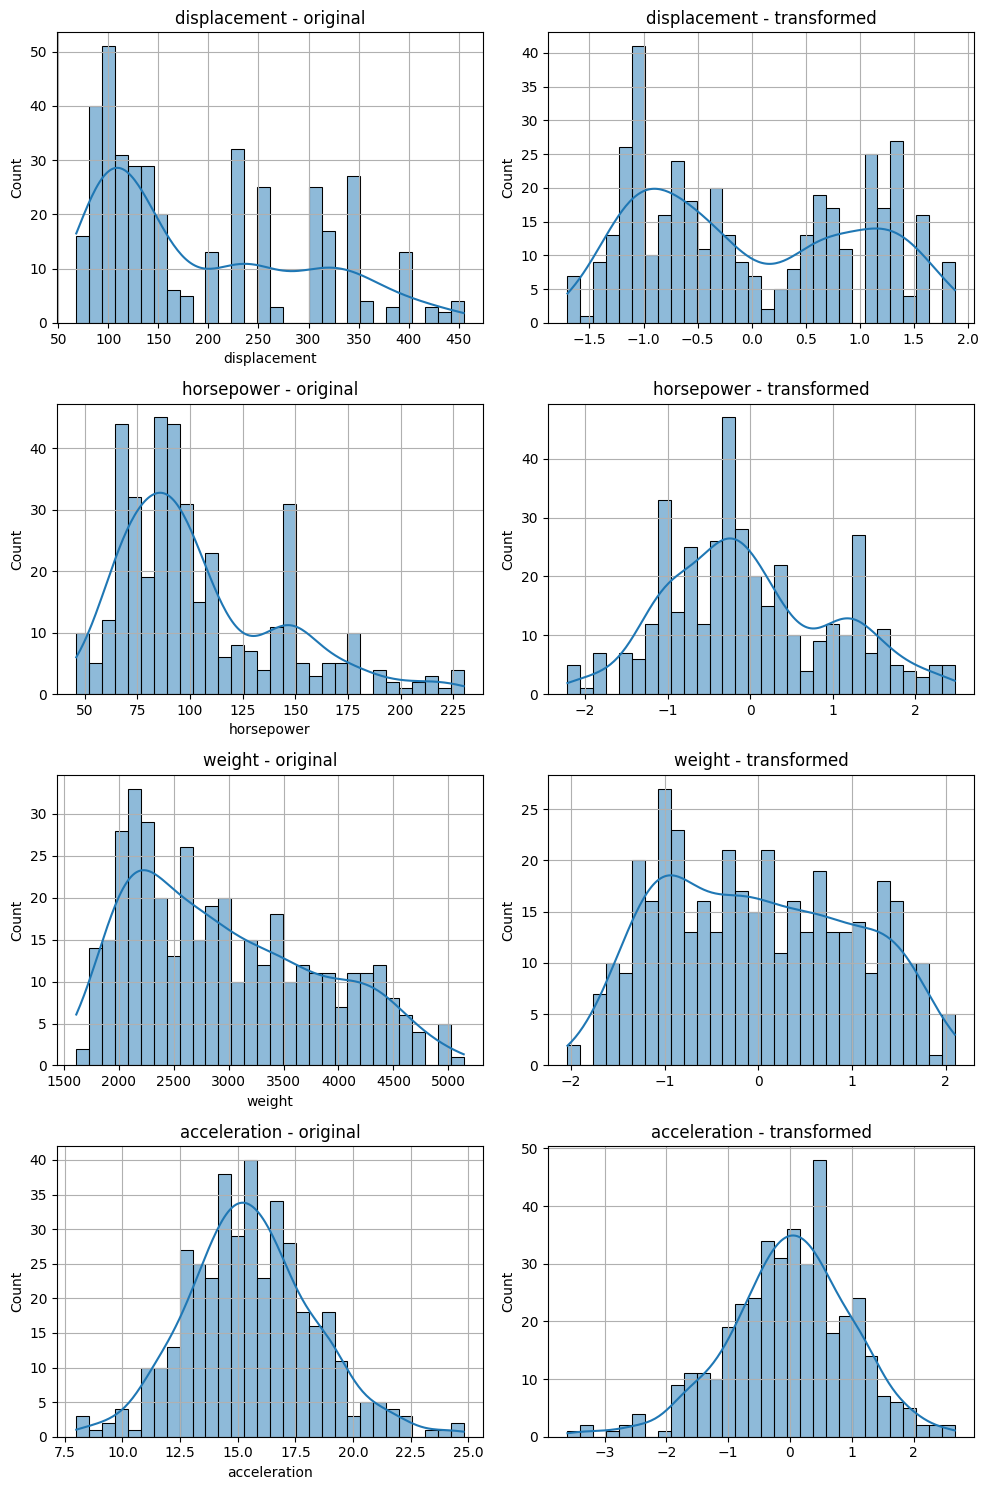

In [4]:
# Define columns that will be normally distributed
features = ["displacement", "horsepower", "weight", "acceleration"]
features_transformed = ["displacement", "horsepower", "weight", "acceleration"]

# Define a scaler to normalize/standardize the data
# scaler = MinMaxScaler()
scaler = StandardScaler()

_, axes = plt.subplots(len(features), 2, figsize=(10, 15))

for index, feature in enumerate(features):
    # Calculate the normal distribution of the feature and standardize it
    feature_data_transformed = scaler.fit_transform(
        np.log(data[feature].values).reshape(-1, 1)
    )
    sns.histplot(data[feature], bins=30, kde=True, ax=axes[index, 0])
    sns.histplot(feature_data_transformed, bins=30, kde=True, ax=axes[index, 1])
    axes[index, 0].set_title(f"{feature} - original")
    axes[index, 1].set_title(f"{feature} - transformed")
    axes[index, 0].legend([], [], frameon=False)
    axes[index, 1].legend([], [], frameon=False)
    axes[index, 0].grid(True)
    axes[index, 1].grid(True)

    # If the feature is normally distributed, we will use the transformed data
    if feature in features_transformed:
        data[feature] = feature_data_transformed

plt.tight_layout()
plt.show()

### Data Preprocessing


In [5]:
# Remove the cylinders column it is highly correlated with the displacement column
data = data.drop(columns=["cylinders"])

# Impute missing values with mean or KNN
data["horsepower"].fillna(
    data["horsepower"].mean(), inplace=True
)  # Impute missing values with the mean
# data.iloc[:, :] = KNN(k=50).fit_transform(data)  # Impute missing values with KNN

# One-hot encode the categorical features
data = pd.get_dummies(data, columns=["model_year"], drop_first=True)

### Data Splitting


In [6]:
# Split the data into training and testing sets (80% training, 20% testing)
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Linear Regression Model


In [7]:
# Build a linear regression model using the scikit-learn
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)

# Predict the MPG for the testing set
sklearn_y_prediction = sklearn_model.predict(X_test)

# Build a linear regression model using the statsmodels
statsmodels_X_train = sm.add_constant(X_train.astype(int))
statsmodels_model = sm.OLS(y_train, statsmodels_X_train).fit()
statsmodels_y_prediction = statsmodels_model.predict(sm.add_constant(X_test))

### My Linear Regression Model


In [8]:
class MyLinearRegression:
    def __init__(self):
        """
        Initialize the MyLinearRegression model.
        """
        self.coefficients = None
        self.intercept = None

    def fit(self, X, y):
        """
        Fit the linear regression model to the data.

        Parameters:
        - X Array: The feature matrix.
        - y Array: The target variable.

        The coefficients and intercept are calculated using the least squares
        method.
        """
        # Add a column of ones to the feature matrix for the intercept/bias
        X = np.column_stack((np.ones(len(X)), X))
        # Calculate the coefficients and intercept using the least squares
        # method (with multiplicative inverse of a matrix)
        self.coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
        self.intercept = self.coefficients[0]
        self.coefficients = self.coefficients[1:]

    def predict(self, X):
        """
        Make predictions using the fitted model.

        Parameters:
        - X Array: The feature matrix for prediction.

        Predictions are made using the coefficients and intercept.
        """
        # Add a column of ones to the feature matrix for the intercept/bias
        X = np.column_stack((np.ones(len(X)), X))
        # Return the predictions
        return X @ np.insert(self.coefficients, 0, self.intercept)

In [9]:
# Build a linear regression model using the custom implementation
my_model = MyLinearRegression()
my_model.fit(X_train.astype(np.float64), y_train.astype(np.float64))

# Predict the MPG for the testing set
my_y_prediction = my_model.predict(X_test)

### Model Evaluation


In [10]:
# Calculate the evaluation metrics for the scikit-learn model
sklearn_mae = mean_absolute_error(y_test, sklearn_y_prediction)
sklearn_mse = mean_squared_error(y_test, sklearn_y_prediction)
sklearn_r2 = r2_score(y_test, sklearn_y_prediction)

# Calculate the evaluation metrics for the custom implementation model
my_mae = mean_absolute_error(y_test, my_y_prediction)
my_mse = mean_squared_error(y_test, my_y_prediction)
my_r2 = r2_score(y_test, my_y_prediction)

### Model Comparison


In [11]:
# Compare the evaluation metrics for both models
print("[sckit-learn] Mean Absolute Error:", sklearn_mae)
print("[sckit-learn] Mean Squared Error:", sklearn_mse)
print("[sckit-learn] R-squared:", sklearn_r2)
print("[my] Mean Absolute Error:", my_mae)
print("[my] Mean Squared Error:", my_mse)
print("[my] R-squared:", my_r2)

[sckit-learn] Mean Absolute Error: 1.781242047197918
[sckit-learn] Mean Squared Error: 5.362327814314396
[sckit-learn] R-squared: 0.900266273156398
[my] Mean Absolute Error: 1.7812420471979102
[my] Mean Squared Error: 5.362327814314403
[my] R-squared: 0.9002662731563978


### Diagnostic Plots


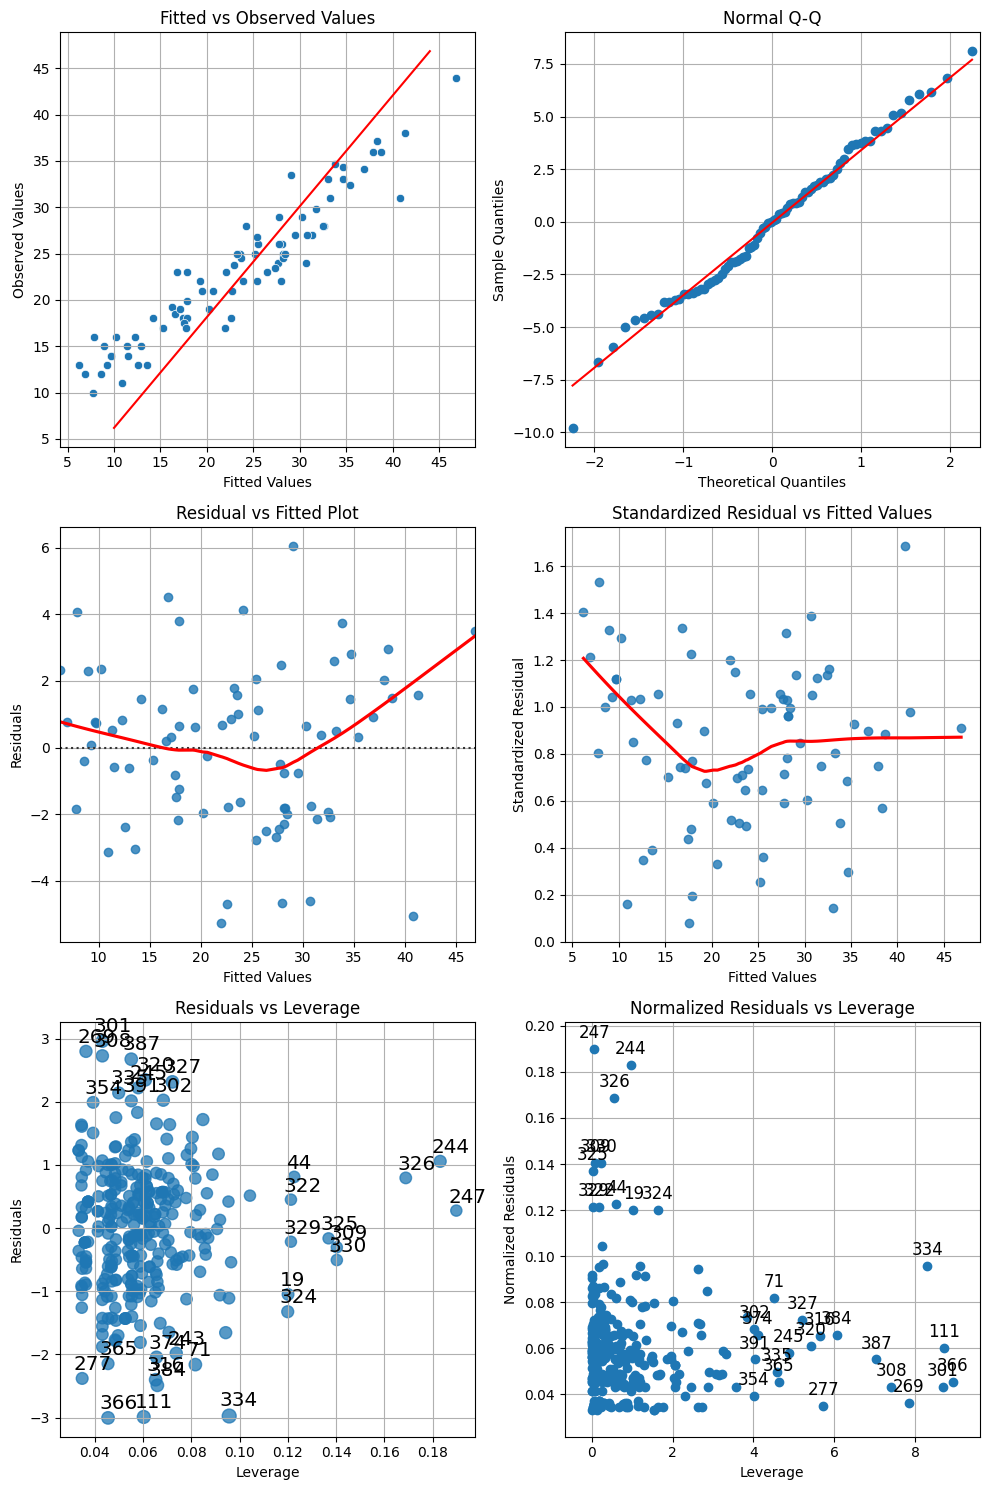

In [12]:
y_prediction = statsmodels_y_prediction.astype(float).values
# y_test = y_test.values

# Calculate the residuals
residuals = y_test - y_prediction

# Calculate the standardized absolute squared residuals
norm_abs_sqrt_residuals = np.sqrt(np.abs(residuals / np.std(residuals)))

# Build a dataframe with the residuals and the predictions
data = pd.DataFrame(
    {
        "originals": y_test,
        "predictions": y_prediction,
        "residuals": residuals,
        "norm_abs_sqrt_residuals": norm_abs_sqrt_residuals,
    }
)

_, ((axis1, axis2), (axis3, axis4), (axis5, axis6)) = plt.subplots(
    3, 2, figsize=(10, 15)
)

# Plot the fitted values against the observed values
sns.scatterplot(data, x="predictions", y="originals", ax=axis1)
axis1.plot(
    [min(data["originals"]), max(data["originals"])],
    [min(data["predictions"]), max(data["predictions"])],
    color="red",
)
axis1.set_title("Fitted vs Observed Values")
axis1.set_xlabel("Fitted Values")
axis1.set_ylabel("Observed Values")
axis1.grid(True)

# Plot the Q-Q plot against the normal distribution
sm.qqplot(residuals, line="s", ax=axis2)
axis2.set_title("Normal Q-Q")
axis2.set_xlabel("Theoretical Quantiles")
axis2.set_ylabel("Sample Quantiles")
axis2.grid(True)

# Plot the residuals against the predicted values
sns.residplot(
    data,
    x="predictions",
    y="residuals",
    lowess=True,
    line_kws=dict(color="r"),
    ax=axis3,
)
axis3.set_title("Residual vs Fitted Plot")
axis3.set_xlabel("Fitted Values")
axis3.set_ylabel("Residuals")
axis3.grid(True)

# Plot the square root of the absolute standardized residuals against the fitted values
sns.regplot(
    data,
    x="predictions",
    y="norm_abs_sqrt_residuals",
    lowess=True,
    line_kws=dict(color="r"),
    ax=axis4,
)
axis4.set_title("Standardized Residual vs Fitted Values")
axis4.set_xlabel("Fitted Values")
axis4.set_ylabel("Standardized Residual")
axis4.grid(True)

# Plot the residuals against the leverage
sm.graphics.influence_plot(
    statsmodels_model,
    ax=axis5,
    size=10,
)
axis5.set_title("Residuals vs Leverage")
axis5.set_xlabel("Leverage", fontsize=10)
axis5.set_ylabel("Residuals", fontsize=10)
axis5.grid(True)

# Plot the normalized residuals against the leverage
sm.graphics.plot_leverage_resid2(statsmodels_model, ax=axis6)
axis6.set_title("Normalized Residuals vs Leverage")
axis6.set_xlabel("Leverage")
axis6.set_ylabel("Normalized Residuals")
axis6.grid(True)

plt.tight_layout()
plt.show()

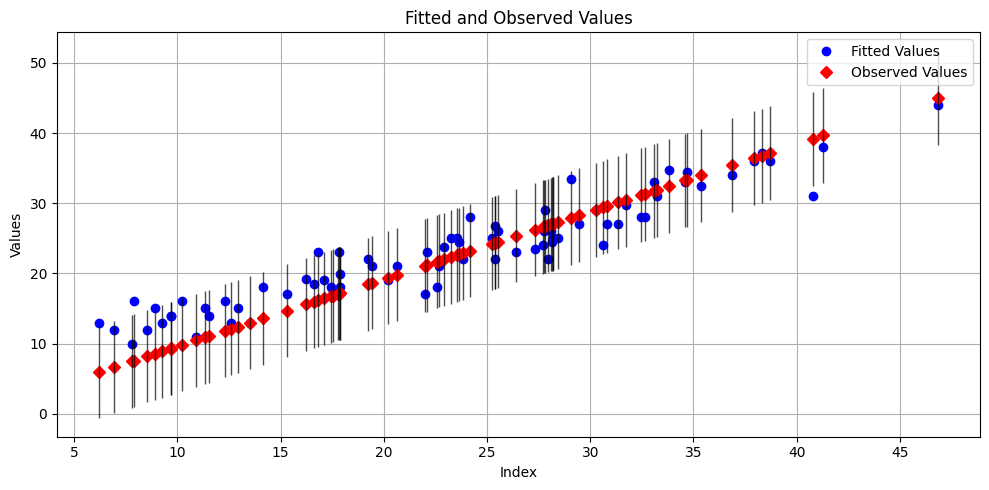

In [13]:
ols_model = sm.OLS(data["originals"], data["predictions"]).fit()

_, axis = plt.subplots(1, figsize=(10, 5))

# Plot the fitted values and the observed values
sm.graphics.plot_fit(ols_model, 0, ax=axis)
axis.set_title("Fitted and Observed Values")
axis.set_xlabel("Index")
axis.set_ylabel("Values")
axis.grid(True)
axis.legend(["Fitted Values", "Observed Values"])
plt.tight_layout()
plt.show()

### Conclusion

##### Dealing with missing values

We have noticed that the `horespower` attribute contains some missing values. We have tried the following approaches, where the best one was to replace the missing values with the mean value of the attribute.

1. Drop data entries with missing values

```json
Mean Absolute Error: 2.4197802491974443
Mean Squared Error: 10.710864418838396
R-squared: 0.7901500386760345
```

2. Replace data entries with missing values with mean

```json
Mean Absolute Error: 2.2533884059317315
Mean Squared Error: 8.19545210407367
R-squared: 0.8475731044779455
```

3. Replace data entries with missing values with KNN

```json
Mean Absolute Error: 2.257009498306658
Mean Squared Error: 8.20517868632478
R-squared: 0.8473922001522598
```

##### Removing unneeded attributes

We have noticed that some attributes are highly correlated to the `mpg` attribute, and some aren't. We have removed the `cylinders` attribute, because it is completely correlated to the `displacement` attribute. We have also tried to remove the `acceleration`, `model_year` and `origin` attribute, because they are not correlated with the `mpg` attribute. We came to the following conclusions: our model improves if we remove the `cylinders` attribute only.

1. Remove the `cylinders` attribute

```json
Mean Absolute Error: 2.2569272184248286
Mean Squared Error: 8.318597387491447
R-squared: 0.845282730132371
```

2. Remove the `acceleration` attribute

```json
Mean Absolute Error: 2.256631270050119
Mean Squared Error: 8.404736185407938
R-squared: 0.8436806379739792
```

3. Remove the `model_year` attribute

```json
Mean Absolute Error: 3.0165279592463525
Mean Squared Error: 13.876550306517071
R-squared: 0.7419105795607494
```

4. Remove the `origin` attribute

```json
Mean Absolute Error: 2.461023675622261
Mean Squared Error: 9.380062867946183
R-squared: 0.8255405748693174
```

##### One-Hot encoding the categorical attributes

Because some of the attributes are categorical we have tried to One-Hot encode all categorical attributes (`model_year` and `origin`). We have tried the following approaches, where the best one was to One-Hot encode only the `model_year` attribute.

1. One-Hot encode `model_year` attribute

```json
Mean Absolute Error: 2.3019758097090937
Mean Squared Error: 8.43155718192249
R-squared: 0.8431817953010424
```

2. One-Hot encode `origin` attribute

```json
Mean Absolute Error: 2.2911466953919954
Mean Squared Error: 8.466202276072208
R-squared: 0.8425374325399342
```

3. One-Hot encode `model_year` and `origin` attribute

```json
Mean Absolute Error: 2.336896399179205
Mean Squared Error: 8.518086616989585
R-squared: 0.8415724376974517
```

##### Normalizing the distribution and standardizing the attributes

At the end, we have also tried to calculate the normal attribute distribution of each feature (`displacement`, `horsepower`, `weight`, `acceleration`) by taking the natural logarithm of each original data. Transformed data was then standardized, meaning that the data has a mean of 0 and a standard deviation of 1. This way our attributes are more comparable, and also can more closely resemble to the normal distribution. With this approach we got the best results.

Before getting there, we have tried normalizing and standardizing data without transforming it to resemble the normal distribution. The results we got are displayed below.

1. Normalizing the data

```json
Mean Absolute Error: 2.301975809709101
Mean Squared Error: 8.431557181922548
R-squared: 0.8431817953010413
```

2. Standardizing the data

```json
Mean Absolute Error: 2.3019758097090985
Mean Squared Error: 8.431557181922528
R-squared: 0.8431817953010416
```

3. Normal distribution with standardization (final and the best result)

```json
Mean Absolute Error: 1.781242047197918
Mean Squared Error: 5.362327814314396
R-squared: 0.900266273156398
```

##### Choosing the right model

Both, our and sckit-learn's model work the same. That is because we have correctly implemented the linear regression class. After a brief testing, the sckit-learn's model might be a bit more error-prone and faster than ours.

But, what really matters are results. We have managed to achieve the exactly the same results with both models.

##### Choosing the right metric

We have evaluated our model with three metrics: `Mean Absolute Error`, `Mean Squared Error`, and `R-squared`. The best model returned the following results.

```json
Mean Absolute Error: 1.781242047197918
Mean Squared Error: 5.362327814314396
R-squared: 0.900266273156398
```

Mean Squared Error (MSE):

- Interpretation: MSE measures the average squared difference between the predicted values and the actual values. It quantifies the overall accuracy of a regression model.
- Scale: MSE is reported in the squared units of the target variable (e.g., square of dollars for a financial prediction).
- Lower Values Are Better: A lower MSE indicates better model performance. It represents smaller prediction errors and suggests that the model's predictions are closer to the actual values. However, MSE heavily penalizes larger errors.

Mean Absolute Error (MAE):

- Interpretation: MAE measures the average absolute difference between the predicted values and the actual values. It quantifies the average magnitude of prediction errors.
- Scale: MAE is reported in the same units as the target variable (e.g., dollars for a financial prediction).
- Interpretability: MAE is easy to interpret, as it represents the average absolute error between predictions and actual values.
  Lower Values Are Better: A lower MAE indicates better model performance. It suggests that, on average, the model's predictions are closer to the actual values.

R-squared (R²):

- Interpretation: R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables in your model. It quantifies how well the model explains the variability in the data.
- Range: R² values range from 0 to 1. An R² of 0 means the model does not explain any of the variance, while an R² of 1 indicates that the model perfectly explains all the variance.
- Higher Values Are Better: A higher R² suggests that a larger proportion of the variance in the target variable is explained by the model. It indicates a better fit to the data.
- Limitations: Be cautious when interpreting R², especially in the presence of many predictors. A high R² may not necessarily imply a useful model if it is overfitted or includes irrelevant features.

##### Summary

While your linear regression model demonstrates a reasonable fit to the data and exhibits statistically significant predictor coefficients, further improvement is possible. Address potential outliers and influential points, explore advanced feature engineering, and consider data expansion. Thoroughly analyze residuals, apply regularization, and evaluate performance with diverse metrics, including MRSE. Additionally, inspect predicted values with each attribute to identify discrepancies and ensure that documentation is comprehensive.
